# Project on recommander systems : Second Environment

#### Author : Raymond Kuoch and Alexandre Maxinsang

In [93]:
# Import packages
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dropout, Dense
from keras.models import Model
from keras import regularizers
from keras.utils import plot_model
from IPython.display import Image
from keras.callbacks import EarlyStopping

from surprise import Dataset, Reader
from surprise import SVD

In [4]:
# Define IP adress of each environnement and the login
url_env = {"first_env":"http://52.47.62.31", 
           "second_env":"http://35.180.254.42", 
           "third_env":"http://35.180.178.243"}
user_id = 'Y6EKWA0GK1D0VCTN0RT7'

## Second environnement : Explicit feedback with covariates

### 1) Get the data

In [5]:
url_reset = url_env["second_env"] + "/reset"
url_predict = url_env["second_env"] + "/predict"
params = {"user_id" : user_id}

def load_data(url_reset,params) :
    r = requests.get(url=url_reset, params=params)
    data = r.json()
    return data

def mean_square_error(true, predicted):
    return (true - predicted) ** 2

def mean_absolute_error(true, predicted):
    return np.abs(true - predicted)

data = load_data(url_reset,params)
data.keys()

dict_keys(['item_history', 'nb_items', 'nb_users', 'next_item', 'next_user', 'next_variables', 'rating_history', 'user_history', 'variables_history'])

In [6]:
user_history = data["user_history"]
item_history = data["item_history"]
rating_history = data["rating_history"]
variables_history = data["variables_history"]

train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history, "meta_data" : variables_history})
train_ratings.head(5)

,user_id,item_id,rating,meta_data
0,7,78,2,"[2.0229713310147543, 0.42495590999159794, 3.40..."
1,27,260,4,"[0.8901757698061652, 0.28177368044240225, -0.7..."
2,84,200,1,"[-1.1902549853172952, -2.1600596464800983, -1...."
3,29,152,2,"[1.5171732006877425, 2.8021736438877367, 1.348..."
4,45,136,5,"[0.054679361852992714, 2.1380702017779543, 0.4..."


In [6]:
# Get the number of users and items
print("There are %d users and %d items." % (data["nb_users"], data["nb_items"]))

There are 100 users and 300 items.


### 2) Model without using covariates

#### 2.1) Constant agent

Let's start with a baseline : constant agent, for instance an agent who predicts the value 3 for each pair (user_id, item_id).

The performance metric will be MSE over 1000 steps on 3 independent run.

In [7]:
mean = 0

for i in range(0, 3) :

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000

    prediction = 3
    params["predicted_score"] = prediction

    mse = 0
    
    for j in range(nb_samples) : 
        time.sleep(0.5)
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        mse += mean_square_error(rating, prediction)
    
    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))
    
print("--------------------------------------------")
print("Mean of the MSE on 3 independant runs %.4f" % (mean/3))

MSE over 1000 samples on the run 0 : 1.7300 
MSE over 1000 samples on the run 1 : 1.7600 
MSE over 1000 samples on the run 2 : 2.0300 
--------------------------------------------
Mean of the MSE on 3 independant runs 1.8400


#### 2.2) Matrix factorisation approach with deep learning

> <font color='blue'>
    First of all, let's use the best model from the lab 1 which a deep model with 2 FC layers and let's try to outperform the constant agent.
    </font>

In [7]:
def recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs])
    x = Dense(64, activation='relu')(input_vecs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    history = model.fit([train_ratings["user_id"], train_ratings["item_id"]], train_ratings["rating"],
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True)
    
    return model, history

In [10]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 0s 226us/step - loss: 8.8137 - val_loss: 8.1782
Epoch 2/50
1800/1800 [==============================] - 0s 22us/step - loss: 5.2869 - val_loss: 2.5112
Epoch 3/50
1800/1800 [==============================] - 0s 25us/step - loss: 1.5573 - val_loss: 1.3336
Epoch 4/50
1800/1800 [==============================] - 0s 32us/step - loss: 0.9100 - val_loss: 1.1479
Epoch 5/50
1800/1800 [==============================] - 0s 28us/step - loss: 0.7851 - val_loss: 1.1658
Epoch 6/50
1800/1800 [==============================] - 0s 23us/step - loss: 0.7364 - val_loss: 1.1778
Epoch 7/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.7452 - val_loss: 1.1573
Epoch 8/50
1800/1800 [==============================] - 0s 27us/step - loss: 0.7352 - val_loss: 1.1469
Epoch 9/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.7136 - val_loss: 1.1540
Epoch

> <font color='blue'>
    On average, the MSE is about 0.84, compared to the baseline with a MSE of 1.8.
    </font>
    
> <font color='blue'>
    **We can think that since there is little training data, it may be more preferable to use a less deep method with fewer FC layers, like 1 FC layer.**

In [18]:
def recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs])
    x = Dense(64, activation='relu')(input_vecs)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    history = model.fit([train_ratings["user_id"], train_ratings["item_id"]], train_ratings["rating"],
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True)
    
    return model, history

In [19]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 1s 371us/step - loss: 9.8497 - val_loss: 8.0194
Epoch 2/50
1800/1800 [==============================] - 0s 28us/step - loss: 6.2673 - val_loss: 3.3526
Epoch 3/50
1800/1800 [==============================] - 0s 25us/step - loss: 1.9987 - val_loss: 1.4196
Epoch 4/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.9553 - val_loss: 1.0161
Epoch 5/50
1800/1800 [==============================] - 0s 27us/step - loss: 0.6868 - val_loss: 0.8983
Epoch 6/50
1800/1800 [==============================] - 0s 28us/step - loss: 0.6125 - val_loss: 0.8598
Epoch 7/50
1800/1800 [==============================] - 0s 26us/step - loss: 0.5908 - val_loss: 0.8178
Epoch 8/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.5839 - val_loss: 0.8071
Epoch 9/50
1800/1800 [==============================] - 0s 23us/step - loss: 0.5837 - val_loss: 0.8022
Epoch

1800/1800 [==============================] - 0s 30us/step - loss: 0.4269 - val_loss: 0.7361
Epoch 29/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.4210 - val_loss: 0.7638
Epoch 30/50
1800/1800 [==============================] - 0s 19us/step - loss: 0.4179 - val_loss: 0.7515
Epoch 31/50
1800/1800 [==============================] - 0s 19us/step - loss: 0.4074 - val_loss: 0.7454
Epoch 32/50
1800/1800 [==============================] - 0s 22us/step - loss: 0.4055 - val_loss: 0.7351
Epoch 33/50
1800/1800 [==============================] - 0s 18us/step - loss: 0.3922 - val_loss: 0.7289
Epoch 34/50
1800/1800 [==============================] - 0s 22us/step - loss: 0.3924 - val_loss: 0.7325
Epoch 35/50
1800/1800 [==============================] - 0s 21us/step - loss: 0.3815 - val_loss: 0.7429
Epoch 36/50
1800/1800 [==============================] - 0s 22us/step - loss: 0.3766 - val_loss: 0.7448
Epoch 37/50
1800/1800 [==============================] - 0s 26us/step - loss

> <font color='blue'>
    **Thus, by using fewer parameters (because fewer FC layers), the model is much more efficient! Because we have very little data (only 2000 lines of data)**
    </font>

> <font color='blue'>
    Let's try to add some L2 regularization to the model and let's see if it is improving MSE.
    </font>

In [20]:
def recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs])
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_vecs)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    history = model.fit([train_ratings["user_id"], train_ratings["item_id"]], train_ratings["rating"],
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True)
    
    return model, history

In [21]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 1s 601us/step - loss: 10.7206 - val_loss: 8.3998
Epoch 2/50
1800/1800 [==============================] - 0s 27us/step - loss: 7.1847 - val_loss: 4.1083
Epoch 3/50
1800/1800 [==============================] - 0s 28us/step - loss: 2.7773 - val_loss: 2.1188
Epoch 4/50
1800/1800 [==============================] - 0s 30us/step - loss: 1.5482 - val_loss: 1.6481
Epoch 5/50
1800/1800 [==============================] - 0s 36us/step - loss: 1.2053 - val_loss: 1.4596
Epoch 6/50
1800/1800 [==============================] - 0s 31us/step - loss: 1.0542 - val_loss: 1.3401
Epoch 7/50
1800/1800 [==============================] - 0s 31us/step - loss: 0.9656 - val_loss: 1.2837
Epoch 8/50
1800/1800 [==============================] - 0s 27us/step - loss: 0.9116 - val_loss: 1.2421
Epoch 9/50
1800/1800 [==============================] - 0s 36us/step - loss: 0.8590 - val_loss: 1.2018
Epoc

1800/1800 [==============================] - 0s 29us/step - loss: 0.6472 - val_loss: 0.7996
Epoch 29/50
1800/1800 [==============================] - 0s 29us/step - loss: 0.6439 - val_loss: 0.7992
Epoch 30/50
1800/1800 [==============================] - 0s 33us/step - loss: 0.6435 - val_loss: 0.8063
Epoch 31/50
1800/1800 [==============================] - 0s 29us/step - loss: 0.6330 - val_loss: 0.8106
Epoch 32/50
1800/1800 [==============================] - 0s 29us/step - loss: 0.6293 - val_loss: 0.7928
Epoch 33/50
1800/1800 [==============================] - 0s 28us/step - loss: 0.6270 - val_loss: 0.7873
Epoch 34/50
1800/1800 [==============================] - 0s 27us/step - loss: 0.6266 - val_loss: 0.7857
Epoch 35/50
1800/1800 [==============================] - 0s 28us/step - loss: 0.6216 - val_loss: 0.7768
Epoch 36/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.6199 - val_loss: 0.7780
Epoch 37/50
1800/1800 [==============================] - 0s 28us/step - loss

> <font color='blue'>
    Thus, by adding regularization, it degrades performance because the model is not overfitting. Regularization is not effective here.
    </font>

### 3) Model with using covariates

In [29]:
def recommender_system_deep_covariates(user, item, variable_history, rating, embedding_size, nb_users, nb_items) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    meta_input = Input(shape=[5], name='meta_item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs, meta_input])
    x = Dense(64, activation='relu')(input_vecs)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    history = model.fit([user, item, variable_history], rating,
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True)
    
    return model, history

In [32]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    variable_history = np.array(data["variables_history"])
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]
    next_variable = np.array(data["next_variables"])

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_covariates(train_ratings["user_id"], train_ratings["item_id"], \
                                                        variable_history, train_y, embedding_size, nb_users,\
                                                        nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item], next_variable.reshape(1, 5)])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        next_variable = np.array(next_data["next_variables"])
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 1s 621us/step - loss: 9.5742 - val_loss: 6.8508
Epoch 2/50
1800/1800 [==============================] - 0s 29us/step - loss: 5.0495 - val_loss: 3.2066
Epoch 3/50
1800/1800 [==============================] - 0s 35us/step - loss: 2.4348 - val_loss: 2.0816
Epoch 4/50
1800/1800 [==============================] - 0s 35us/step - loss: 1.5264 - val_loss: 1.5121
Epoch 5/50
1800/1800 [==============================] - 0s 35us/step - loss: 0.9475 - val_loss: 1.2050
Epoch 6/50
1800/1800 [==============================] - 0s 31us/step - loss: 0.6937 - val_loss: 1.0443
Epoch 7/50
1800/1800 [==============================] - 0s 29us/step - loss: 0.5851 - val_loss: 0.9812
Epoch 8/50
1800/1800 [==============================] - 0s 45us/step - loss: 0.5321 - val_loss: 0.9421
Epoch 9/50
1800/1800 [==============================] - 0s 30us/step - loss: 0.5058 - val_loss: 0.9166
Epoch

1800/1800 [==============================] - 0s 35us/step - loss: 0.3999 - val_loss: 0.8225
Epoch 29/50
1800/1800 [==============================] - 0s 34us/step - loss: 0.3951 - val_loss: 0.7892
Epoch 30/50
1800/1800 [==============================] - 0s 26us/step - loss: 0.3906 - val_loss: 0.8017
Epoch 31/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.3801 - val_loss: 0.8023
Epoch 32/50
1800/1800 [==============================] - 0s 27us/step - loss: 0.3725 - val_loss: 0.8135
Epoch 33/50
1800/1800 [==============================] - 0s 24us/step - loss: 0.3605 - val_loss: 0.8034
Epoch 34/50
1800/1800 [==============================] - 0s 24us/step - loss: 0.3490 - val_loss: 0.8076
Epoch 35/50
1800/1800 [==============================] - 0s 25us/step - loss: 0.3356 - val_loss: 0.8284
Epoch 36/50
1800/1800 [==============================] - 0s 24us/step - loss: 0.3307 - val_loss: 0.8144
Epoch 37/50
1800/1800 [==============================] - 0s 24us/step - loss

> <font color='blue'>
    We observe that the validation loss starts to increase in the last epochs. So we will use now Early Stopping to avoid this.
    </font>

In [41]:
def recommender_system_deep_covariates_early_stop(user, item, variable_history, rating, embedding_size, nb_users, nb_items, verbose=True) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    meta_input = Input(shape=[5], name='meta_item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs, meta_input])
    x = Dense(64, activation='relu')(input_vecs)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    history = model.fit([user, item, variable_history], rating,
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True, verbose=verbose, callbacks=[early_stopping])
    
    return model, history

In [43]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    variable_history = np.array(data["variables_history"])
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]
    next_variable = np.array(data["next_variables"])

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_covariates_early_stop(train_ratings["user_id"], train_ratings["item_id"], \
                                                        variable_history, train_y, embedding_size, nb_users,\
                                                        nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item], next_variable.reshape(1, 5)])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        next_variable = np.array(next_data["next_variables"])
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 2s 1ms/step - loss: 9.4843 - val_loss: 6.4334
Epoch 2/50
1800/1800 [==============================] - 0s 34us/step - loss: 4.4285 - val_loss: 2.3791
Epoch 3/50
1800/1800 [==============================] - 0s 36us/step - loss: 1.8600 - val_loss: 1.6224
Epoch 4/50
1800/1800 [==============================] - 0s 36us/step - loss: 1.1695 - val_loss: 1.1278
Epoch 5/50
1800/1800 [==============================] - 0s 37us/step - loss: 0.7970 - val_loss: 0.9093
Epoch 6/50
1800/1800 [==============================] - ETA: 0s - loss: 0.647 - 0s 37us/step - loss: 0.6536 - val_loss: 0.8330
Epoch 7/50
1800/1800 [==============================] - 0s 37us/step - loss: 0.5876 - val_loss: 0.7957
Epoch 8/50
1800/1800 [==============================] - 0s 38us/step - loss: 0.5542 - val_loss: 0.7613
Epoch 9/50
1800/1800 [==============================] - 0s 38us/step - loss: 0.5377 - 

Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 3s 1ms/step - loss: 7.3977 - val_loss: 5.1457
Epoch 2/50
1800/1800 [==============================] - 0s 40us/step - loss: 3.3322 - val_loss: 2.4844
Epoch 3/50
1800/1800 [==============================] - 0s 38us/step - loss: 1.7772 - val_loss: 1.8019
Epoch 4/50
1800/1800 [==============================] - 0s 37us/step - loss: 1.1298 - val_loss: 1.2987
Epoch 5/50
1800/1800 [==============================] - 0s 38us/step - loss: 0.7613 - val_loss: 1.0517
Epoch 6/50
1800/1800 [==============================] - 0s 40us/step - loss: 0.6306 - val_loss: 0.9374
Epoch 7/50
1800/1800 [==============================] - 0s 37us/step - loss: 0.5830 - val_loss: 0.8449
Epoch 8/50
1800/1800 [==============================] - 0s 35us/step - loss: 0.5607 - val_loss: 0.8145
Epoch 9/50
1800/1800 [==============================] - 0s 37us/step - loss: 0.5453 - val_loss: 0.7763
Epoch 10/50
1800/1800 [====

### 3) Conclusion 

After many tests : we have arrived at the following model which allows us to have the best MSE : 
- Deep model with 1 FC layer
- 1 FC layer with 128 neuron units
- Use Drop out (0.5)
- with using Early Stopping
- MSE over 1000 samples on the run 0 : 0.6388 
- MSE over 1000 samples on the run 1 : 0.7189 
- MSE over 1000 samples on the run 2 : 0.5353 
- Mean of the MSE on 3 independant runs 0.6310 

In [97]:
def recommender_system_deep_covariates_early_stop(user, item, variable_history, rating, embedding_size, nb_users, nb_items, verbose=True) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    meta_input = Input(shape=[5], name='meta_item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs, meta_input])
    x = Dense(128, activation='relu')(input_vecs)
    x = Dropout(0.5)(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit([user, item, variable_history], rating,
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True, verbose=verbose, callbacks=[early_stopping])
    
    return model, history

In [100]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    variable_history = np.array(data["variables_history"])
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]
    next_variable = np.array(data["next_variables"])

    nb_samples = 200
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_covariates_early_stop(train_ratings["user_id"], train_ratings["item_id"], \
                                                        variable_history, train_y, embedding_size, nb_users,\
                                                        nb_items, verbose=False)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item], next_variable.reshape(1, 5)])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        next_variable = np.array(next_data["next_variables"])
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
MSE over 1000 samples on the run 0 : 0.6388 
MSE over 1000 samples on the run 1 : 0.7189 
MSE over 1000 samples on the run 2 : 0.5353 
Mean of the MSE on 3 independant runs 0.6310 
-------------------------------------------


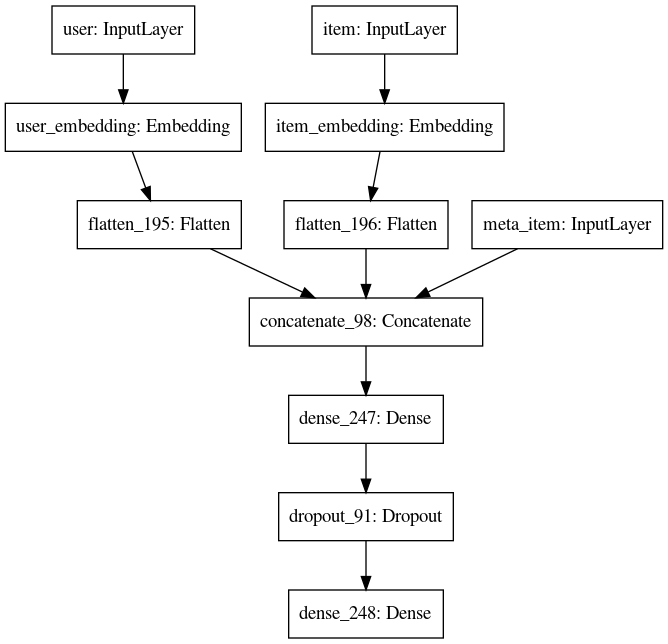

In [94]:
plot_model(model, to_file='model.png')
Image(filename='model.png') 